# Demo with esgf search for CMIP6 at DKRZ site (subset + average)

ESGF Node at DKRZ: https://esgf-data.dkrz.de/search/cmip6-dkrz/

## Use esgf search at DKRZ ... no distributed search



Using ``esgf-pyclient``: 
https://esgf-pyclient.readthedocs.io/en/latest/notebooks/examples/search.html

In [1]:
from pyesgf.search import SearchConnection
conn = SearchConnection('http://esgf-data.dkrz.de/esg-search',
                        distrib=False)

**Search only CMIP6 files locally available at DKRZ**

In [2]:
ctx = conn.new_context(project='CMIP6', data_node='esgf1.dkrz.de,esgf3.dkrz.de', latest=True, replica=True)
ctx.hit_count

538340

Select only one dataset

In [3]:
# CMIP6.ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.r1i1p1f1.day.tasmax.gr

results = ctx.search(
    institution_id='EC-Earth-Consortium',
    source_id='EC-Earth3',
    experiment_id='ssp585', 
    variable='tas', 
    frequency='day',
    variant_label='r1i1p1f1'
)
len(results)

1

In [4]:
ds = results[0]
ds.json

{'id': 'CMIP6.ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.r1i1p1f1.day.tas.gr.v20200310|esgf3.dkrz.de',
 'version': '20200310',
 'access': ['HTTPServer', 'GridFTP', 'OPENDAP', 'Globus', 'LAS'],
 'activity_drs': ['ScenarioMIP'],
 'activity_id': ['ScenarioMIP'],
 'cf_standard_name': ['air_temperature'],
 'citation_url': ['http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6.ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.r1i1p1f1.day.tas.gr.v20200310.json'],
 'data_node': 'esgf3.dkrz.de',
 'data_specs_version': ['01.00.31'],
 'dataset_id_template_': ['%(mip_era)s.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s'],
 'datetime_start': '2015-01-01T12:00:00Z',
 'datetime_stop': '2100-12-31T12:00:00Z',
 'directory_format_template_': ['%(root)s/%(mip_era)s/%(activity_drs)s/%(institution_id)s/%(source_id)s/%(experiment_id)s/%(member_id)s/%(table_id)s/%(variable_id)s/%(grid_label)s/%(version)s'],
 'east_degrees': 359.296

Get a dataset identifier used by rook

In [5]:
dataset_id = ds.json['instance_id']
dataset_id

'CMIP6.ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.r1i1p1f1.day.tas.gr.v20200310'

Time range

In [6]:
f"{ds.json['datetime_start']}/{ds.json['datetime_stop']})"

'2015-01-01T12:00:00Z/2100-12-31T12:00:00Z)'

Bounding Box: (West, Sout, East, North)

In [7]:
f"({ds.json['west_degrees']}, {ds.json['south_degrees']},{ds.json['east_degrees']}, {ds.json['west_degrees']}, {ds.json['north_degrees']})"


'(0.0, -89.46282,359.29688, 0.0, 89.46282)'

Size in GB

In [8]:
f"{ds.json['size'] / 1024 / 1024 / 1024} GB"

'11.309112574905157 GB'

## Use Rook to run subset + average_by_year

In [9]:
import os
os.environ['ROOK_URL'] = 'http://rook.dkrz.de/wps'
os.environ['ROOK_MODE'] = 'async'

from rooki import operators as ops

Run subset workflow

http://bboxfinder.com/

In [10]:
#start_time: 2016-01-01
#stop_time: 2031-12-31
#minlat: "41" maxlat: "51"
#minlon: "-1" maxlon: "15"

bbox = "-1.0,41.0,15.0,51.0"

tas = ops.Input('tas', [dataset_id])
sub = ops.Subset(tas, time="2016-01-01/2031-12-31", area=bbox)
wf = ops.AverageByTime(sub, freq="year")

resp = wf.orchestrate()
resp.ok

True

### The outputs are available as a Metalink document
https://github.com/metalink-dev

Metalink URL

In [11]:
resp.url

'http://rook4.cloud.dkrz.de:80/outputs/rook/e8384508-b4fd-11ec-a424-fa163ed6c06f/input.meta4'

Number of files

In [12]:
resp.num_files

1

Total size in MB

In [13]:
resp.size_in_mb

0.05859851837158203

Download URLs

In [14]:
resp.download_urls()

['http://rook4.cloud.dkrz.de:80/outputs/rook/08e758f2-b4fe-11ec-ac4b-fa163ed6c06f/tas_day_EC-Earth3_ssp585_r1i1p1f1_gr_20160101-20310101_avg-year.nc']

Download and open with xarray

In [15]:
ds_0 = resp.datasets()[0]
ds_0

<xarray.Dataset>
Dimensions:    (time: 16, lat: 15, bnds: 2, lon: 23)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01 2017-01-01 ... 2031-01-01
  * lat        (lat) float64 41.05 41.75 42.46 43.16 ... 48.77 49.47 50.18 50.88
  * lon        (lon) float64 -0.7031 0.0 0.7031 1.406 ... 13.36 14.06 14.77
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) datetime64[ns] ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time:            0.0
    comment:                Production: Thomas Reerink at KNMI
    contact:                cmip6-data@ec-earth.org
    ...                     ...
    license:                CMIP6 model data produced by EC-Earth-Consortium ...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/1ad61af9-9d15-4149-bd21-5e50937af231
    branch_time_in_child:   60265.0D
    branch_time_in_parent:  60265.0D
    history:                2019-09-27T17:11:09Z ; CMOR rewrote data to be co...

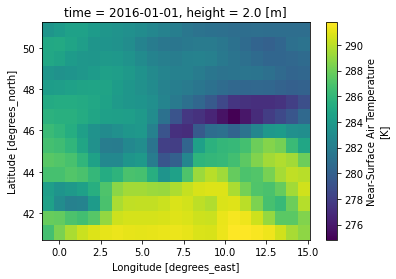

In [16]:
ds_0.tas.isel(time=0).plot()

### Provenance

Provenance information is given using the *PROV* standard.
https://pypi.org/project/prov/

Provenance: URL to json document

In [17]:
resp.provenance()

'http://rook4.cloud.dkrz.de:80/outputs/rook/e8384508-b4fd-11ec-a424-fa163ed6c06f/provenance.json'

Provenance Plot

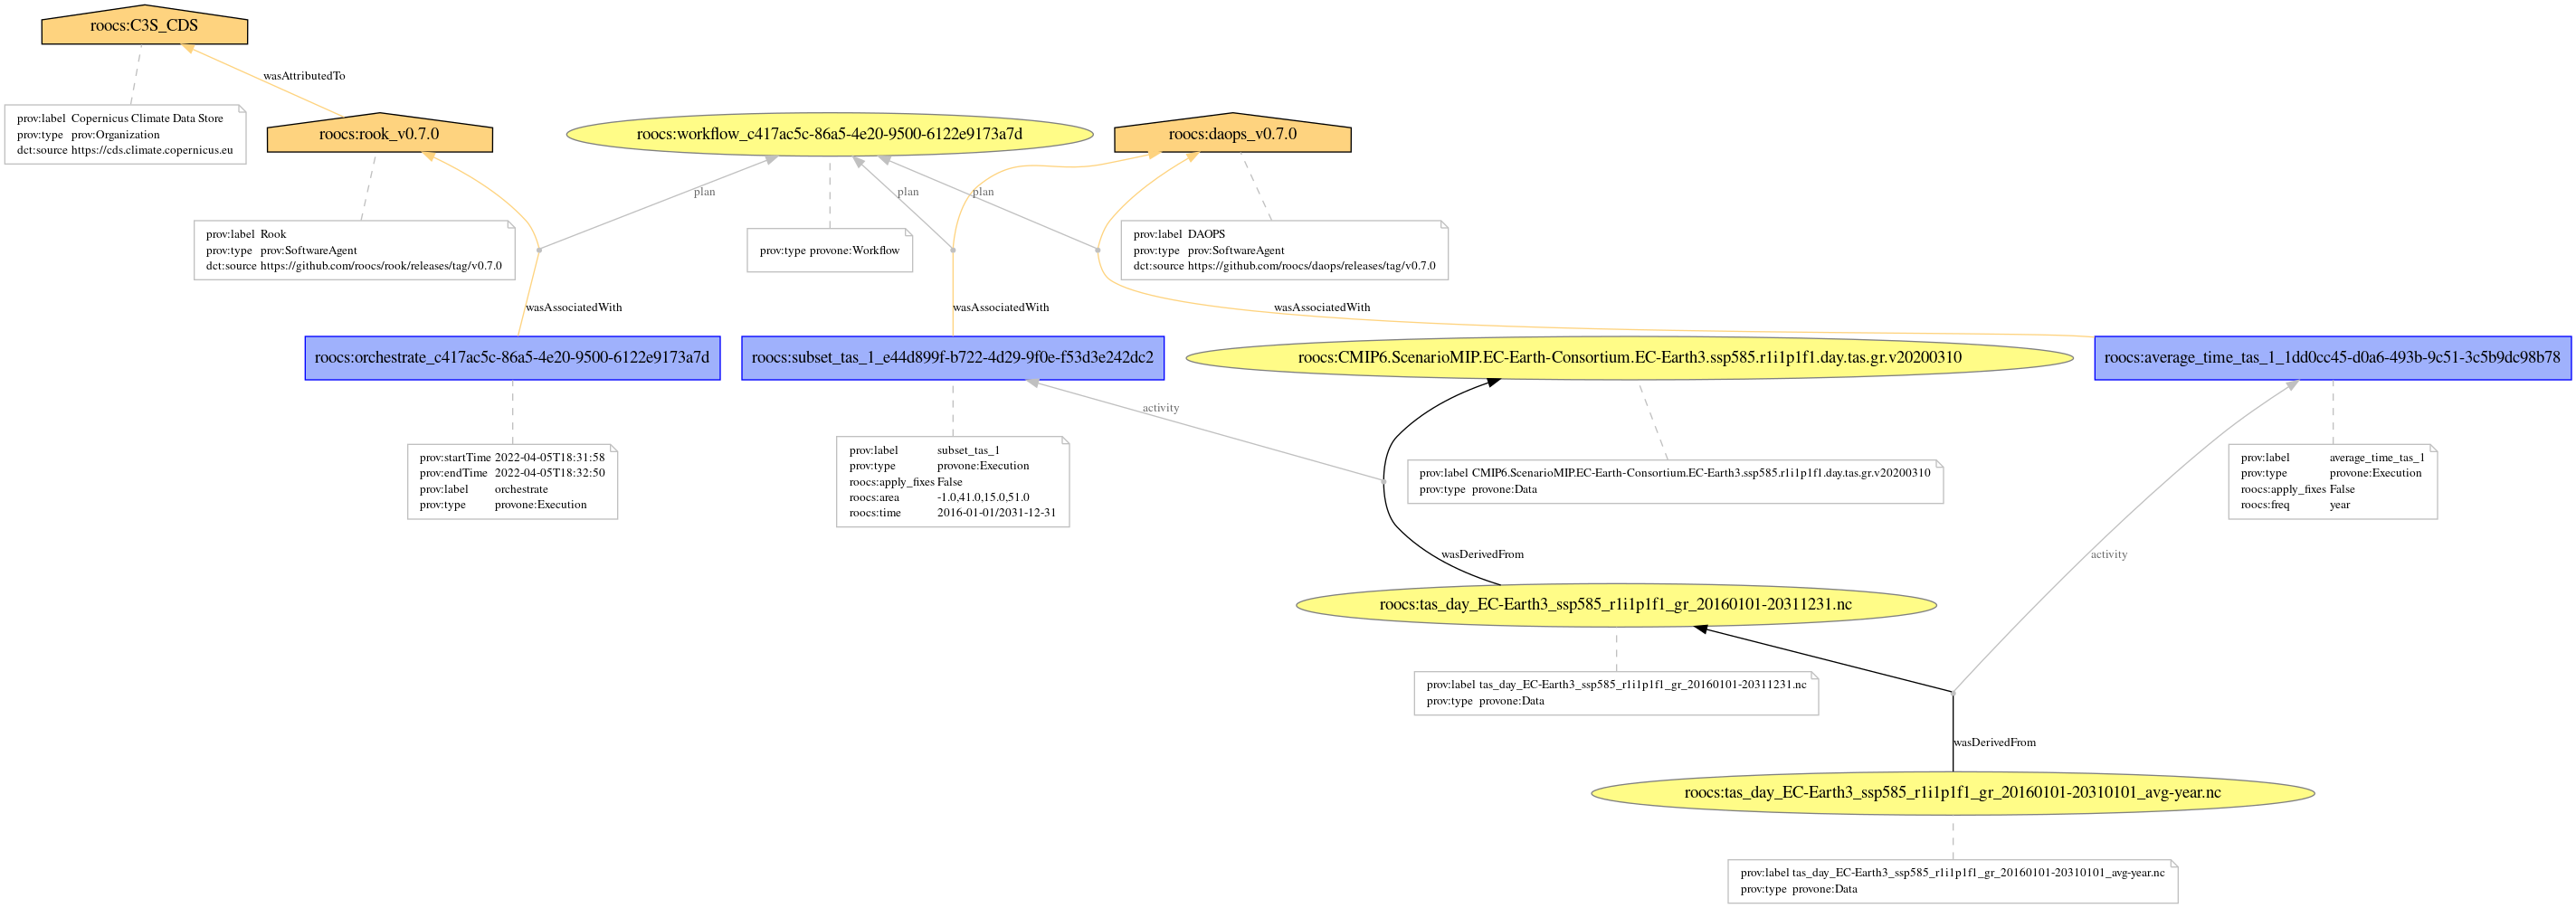

In [18]:
from IPython.display import Image
Image(resp.provenance_image())